In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from decimal import Decimal

from scipy.optimize import minimize
from scipy.stats import norm
from scipy import stats

In [2]:
np.random.seed(14)
returns = np.random.normal(0,1,1000)

In [3]:
mean = returns.mean()
var = returns.std()
epsilon = 1e-6

In [4]:
initial_parameters = (mean, var, 0.1, 0.8)

In [5]:
# Bounds for: mu, alpha0, alpha1, beta1
bounds = ((-10*abs(mean), 10*abs(mean)),
          (epsilon**2, 100*var),
          (epsilon, 1 - epsilon),
          (epsilon, 1 - epsilon))
#bounds = ((0.0001, None), (0.0001, None), (0.0001, None), (0.0001, None))

In [6]:
def garch_filter(parameters, eps):
    iT = len(eps)
    sigma2 = np.zeros(iT)
    
    for i in range(iT):
        if i == 0:
            sigma2[i] = parameters[1]/(1 - parameters[2] - parameters[3])
        else:
            sigma2[i] = parameters[1] + parameters[2] * eps[i-1]**2 + parameters[3] * sigma2[i-1]
            
    return sigma2

In [7]:
def garch_loglike(parameters, eps):
    sigma2 = garch_filter(parameters, eps)
    logL =  len(eps)/2*np.log(2*np.pi) + 0.5*np.sum(np.log(sigma2)) + 0.5 * np.sum(eps**2 / sigma2)
    return logL

In [8]:
def garch_fit(parameters, X):
    res = minimize(garch_loglike, parameters, args = (X),
                  bounds = bounds,
                  options = {'disp': True},
                  method = 'l-bfgs-b')
    return res

In [9]:
model = garch_fit(initial_parameters, returns)
model

      fun: 1446.4353138389233
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  2.27373674e-05,  1.11456757e+01, -2.27373676e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([-8.80413096e-02,  5.57744673e-01,  1.00000000e-06,  4.72098579e-01])

In [25]:
se = np.round(np.diag(model.hess_inv.todense()/len(returns)),4)
se = ['{0:.3E}'.format(item) for item in se]

In [26]:
Parameters = ['Mu', 'Alpha0', 'Alpha1', 'Beta1']
pd.DataFrame(data = {'Parameters': Parameters, 
                     'Estimate': model.x, 
                     'Std. Error': se}) 
#                     'T-stat': np.round(model.x/se,4), 
#                     'p-value': np.round(stats.t.sf(np.abs(model.x/se), 2)**2,4)})

,Parameters,Estimate,Std. Error
0,Mu,-0.088041,1.000E-03
1,Alpha0,0.557745,3.000E-04
2,Alpha1,0.000001,0.000E+00
3,Beta1,0.472099,3.000E-04


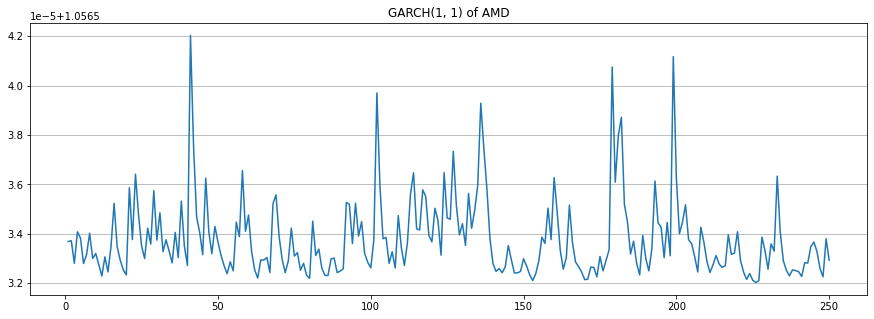

In [12]:
fit = garch_filter(model.x, returns)

plt.figure(figsize=(15,5))
plt.plot(np.linspace(1,250,num = 250),fit[-250:])
plt.title('GARCH(1, 1) of AMD')
plt.grid(axis = 'y')
plt.show()

In [13]:
from arch import arch_model
am = arch_model(returns)

In [14]:
res = am.fit()
res

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5050.968765266147
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1794.7899373619684
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1448.9916728222552
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1442.7133579652923
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1460.90711335737
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1442.6907612959326
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1451.8383054357553
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1445.661409610308
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1444.8714816676822
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1444.6811804621777
Iteration:     11,   Func. Count:     72,   Neg. LLF: 3706.435111322015
Iteration:     12,   Func. Count:     80,   Neg. LLF: 1443.437550200485
Iteration:     13,   Func. Count:     86,   Neg. LLF: 1442.796880476771
Iteration:     14,   Func. Count:     92,   Neg. LLF: 1442

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1442.63
Distribution:                  Normal   AIC:                           2893.25
Method:            Maximum Likelihood   BIC:                           2912.88
                                        No. Observations:                 1000
Date:                Tue, Jan 26 2021   Df Residuals:                      996
Time:                        14:48:14   Df Model:                            4
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.0880  3.240e-02     -2.717  6.592e-03 [ -0.1

In [15]:
fit2 = garch_filter(res.params, returns)

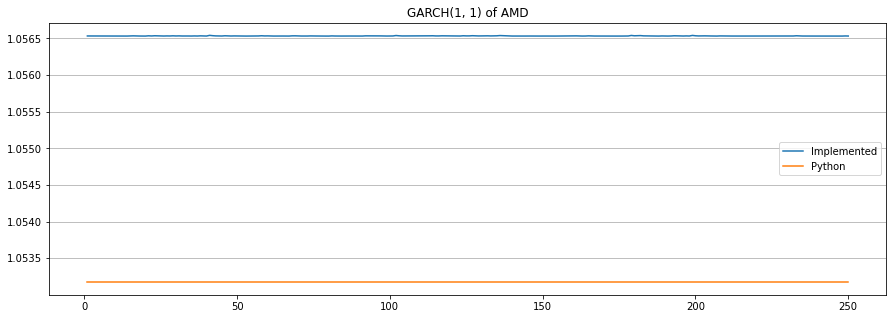

In [16]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(1,250,num = 250),fit[-250:], label = 'Implemented')
plt.plot(np.linspace(1,250,num = 250),fit2[-250:], label = 'Python')
plt.title('GARCH(1, 1) of AMD')
plt.grid(axis = 'y')
plt.legend()
plt.show()